In [10]:
import obspy
from obspy import read 
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
import math
import numpy as np
import pandas as pd
import h5py


In [11]:
file_dir = r"C:\Users\ssarikaya\Documents\GitHub\EQTransformer\ModelsAndSampleData\100samples.hdf5"
csv_file = r"C:\Users\ssarikaya\Documents\GitHub\EQTransformer\ModelsAndSampleData\100samples.csv"

In [12]:
df = pd.read_csv(csv_file)

In [13]:
dtfl = h5py.File(file_dir, 'r')

In [14]:
data = []
data_set = list(dtfl.get("data"))
data = np.array(dtfl.get('data/'+str(data_set[0]))[()])
    
data.shape

(6000, 3)

# **Jittering**
Adding random noise from a Gaussian distribution  with mean = 0 and standart deviation = 0.05

In [15]:
def jittering(data, sigma = 0.05):
  noise = np.random.normal(loc = 0, scale = sigma, size = data.shape)
  return data + noise

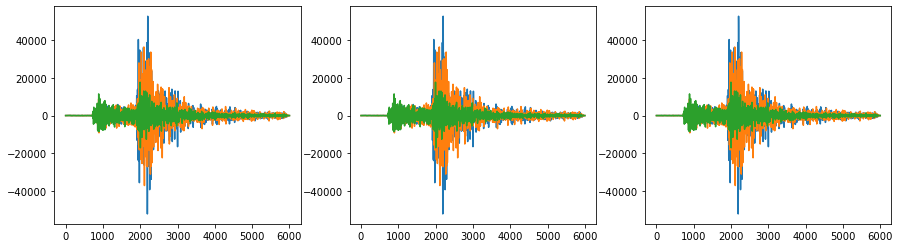

In [16]:

fig = plt.figure(figsize=(15,4))
for ii in range(3):
    ax = fig.add_subplot(1,3,ii+1)
    ax.plot(jittering(data))


# **Rotation**
* Choose an axis and an angle to flip the data. 
* Generate rotation matrix 
* Multiply with data

In [20]:
def rotation(data):
    axis = np.random.uniform(low=-1, high=1, size=data.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(data , axangle2mat(axis,angle))

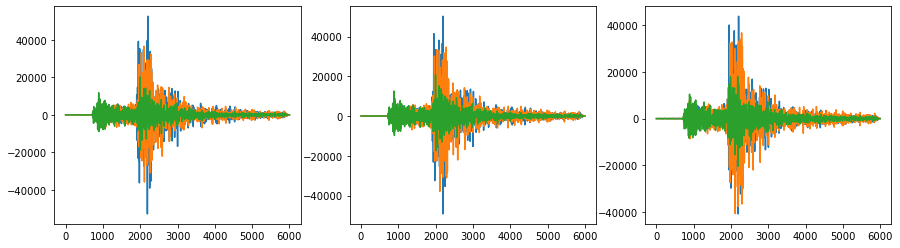

In [21]:
fig = plt.figure(figsize=(15,4))
for ii in range(3):
    ax = fig.add_subplot(1,3,ii+1)
    ax.plot(rotation(data))

# **Scaling**

* Generate scalers by Gaussian distribution
* Multiply the magnitude of all elements in data by the scaler. (it increases or decreases the magnitudes)

In [22]:
def scaling(data, sigma = 0.1):
    scaler = np.random.normal(loc=1, scale = sigma, size = (1, data.shape[1])) # (1,3)
    noise = np.matmul(np.ones((data.shape[0], 1)), scaler) # (6000, 3)
    return data*noise

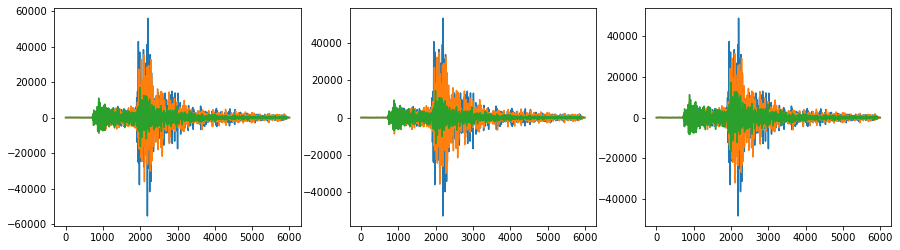

In [23]:
fig = plt.figure(figsize=(15,4))
for ii in range(3):
    ax = fig.add_subplot(1,3,ii+1)
    ax.plot(scaling(data))

# **Magnitude Warping**
The magnitude of each time series is multiplied by a curve created by cubic spline with four knots at random magnitudes

### Cubic spline is a spline constructed of piecewise third-order polynomials which pass through a set of m control points.

### Knots are where different cubic polynomials are joined



In [24]:
def generate_curve(data, sigma = 0.2, knot = 4):
    # independent variables in increasing order. 
    xx = (np.ones((data.shape[1],1))*(np.arange(0, data.shape[0], (data.shape[0]-1)/(knot+1)))).transpose() #(6,3)

    # dependent variables
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, data.shape[1])) #(6,3)
    x_range = np.arange(data.shape[0])
    
    cs_i = []
    for dim in range(data.shape[1]):
        cs = CubicSpline(xx[:,dim], yy[:,dim])
        cs_i.append(cs(x_range))
    
    return np.array(cs_i).transpose()

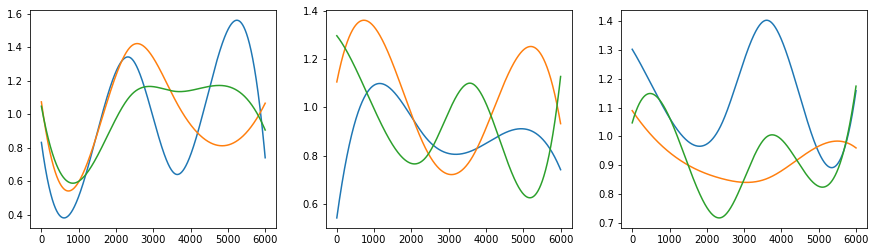

In [25]:
fig = plt.figure(figsize=(15,4))
for ii in range(3):
    ax = fig.add_subplot(1,3,ii+1)
    ax.plot(generate_curve(data))

In [26]:
def magnitute_warp(data, sigma = 0.2):
    return data * generate_curve(data, sigma)

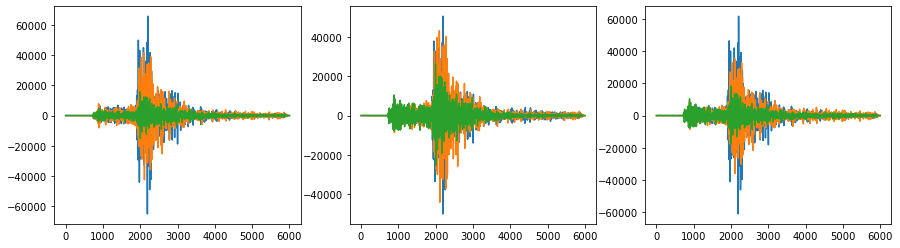

In [27]:
fig = plt.figure(figsize=(15,4))
for ii in range(3):
    ax = fig.add_subplot(1,3,ii+1)
    ax.plot(magnitute_warp(data))

# **Time Warping**

In [28]:
def time_warp(x, sigma=0.2, knot=4):
    orig_steps = np.arange(x.shape[0])
    
    # independent variables
    warp_steps = (np.ones((data.shape[1],1))*(np.arange(0, data.shape[0], (data.shape[0]-1)/(knot+1)))).transpose()
    
    # dependent variables
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, data.shape[1]))
    
    ret = np.zeros_like(x)
    for dim in range(x.shape[1]):
        time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[:,dim])(orig_steps)
        scale = (x.shape[0]-1)/time_warp[-1]
        ret[:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[0]-1), x[:,dim]).T
    return ret

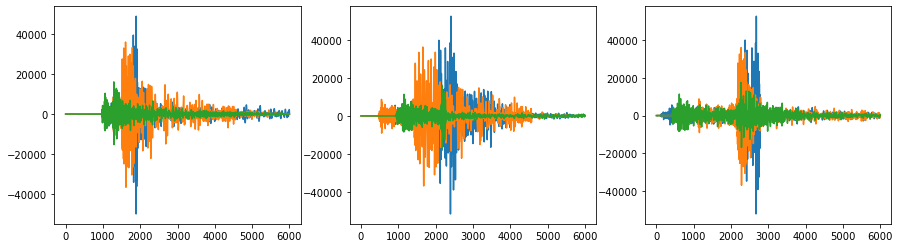

In [29]:
fig = plt.figure(figsize=(15,4))
for ii in range(3):
    ax = fig.add_subplot(1,3,ii+1)
    ax.plot(time_warp(data))

# **Combination**

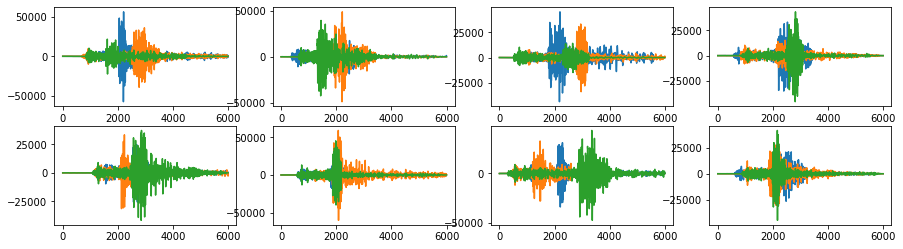

In [30]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(time_warp(scaling(rotation(jittering(data)))))
